<a href="https://colab.research.google.com/github/YoheiMurata/moomoo-lab.keras/blob/master/kobayashi_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 小林さんちのメイドラゴンキャラクターの分類をやってみよう
小林さんちのメイドラゴンのキャラクター（小林、トール、滝谷、カンナ）の分類をできるよう、学習と推測をしてみようと思います。

In [0]:
import glob
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

Google Driveをマウントします

In [0]:
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# データセットを作成
あらかじめGoogle Driveに配置しておいた画像を利用して学習用のデータセットを作成します。

In [0]:
# 画像を格納する用のリスト
datas = []
# 画像に対応したラベル情報のリスト
labels = []                                                                                                                                      

In [0]:
# データセットの画像サイズを指定します。
IMG_SIZE = 120

In [0]:
# 画像のディレクトリパスとラベルを引数に、データセットを作成します
def make_dataset( path, label ):
  files = glob.glob( path + "/*.png")
  random.shuffle(files)
  
  for file in files:
    # 画像をIMG_SIZE　xIMG_SIZE　に加工します
    img = Image.open( file )
    img = img.convert( "RGB" )
    img = img.resize( ( IMG_SIZE, IMG_SIZE ) )
    
    # 画像を-20度〜20度、5度おきに回転させ、なおかつ左右反転することで、同じ画像から
    # データセットを水増しします
    for angle in range( -20, 21, 5 ):
      tmp_image = img.rotate( angle )
      datas.append( make_data( tmp_image ) )
      labels.append( label )
      
      #左右反転
      img_flip = tmp_image.transpose( Image.FLIP_LEFT_RIGHT )
      datas.append( make_data( img_flip ) )
      labels.append( label )
      
# 画像の各ピクセルの値を0~1に正規化する
def make_data( image ):
  data = np.asarray( image )
  data = data / 255
  data = data.reshape( IMG_SIZE, IMG_SIZE, 3 )
  return data
    
    

Google Drive上の画像データを元にデータセットを作成します。
データセットに利用する画像データは、あらかじめキャラクター別にフォルダ分けされているものとします

In [0]:
DATASET_PATH = 'drive/My Drive/kobayashi/kobayashi-02/'
DATASET_NAME = 'kobayashi_dataset.npz'
images = glob.glob(DATASET_PATH + "/*/*.png", recursive=True)

# キャラクターはそれぞれ、小林が０、トールを１といった要領でラベルづけしていきます
make_dataset( DATASET_PATH + "kobayashi", 0 )
make_dataset( DATASET_PATH + "toal", 1 )
make_dataset( DATASET_PATH + "kanna", 2 )
make_dataset( DATASET_PATH + "takiya", 3 )

datas = np.array( datas, dtype = np.float32 )

np.savez( DATASET_PATH + DATASET_NAME, X = datas, y = labels )

# ニューラルネットワークの定義と学習
ニューラルネットワークを定義して、作成したデータセットを元に学習をします。

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D, Activation
from keras.utils import to_categorical
from keras.optimizers import Adam
# 学習用データを訓練データとテスト用データに分類するための関数をインポート
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
# データセットを読み込みます
data = np.load(DATASET_PATH + DATASET_NAME)
X = data['X']
y = data['y']
# 左から、訓練用画像、テスト用画像、訓練用ラベル、テスト用ラベル
x_train, x_test, y_train, y_test = train_test_split(X, y)
# 長さ４のone-hot表現を定義します
y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)

ニューラルネットを定義します。

In [0]:
model = Sequential()
model.add(Conv2D(32, 3, activation = 'relu', input_shape = (IMG_SIZE, IMG_SIZE, 3)))
model.add(Conv2D(32, 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation = 'softmax'))

adam = Adam( lr = 1e-4 )

model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




fitメソッドで学習を行います

In [0]:
history = model.fit(x_train, y_train, validation_split = 0.1, epochs = 60)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 9525 samples, validate on 1059 samples
Epoch 1/60





9525/9525 [==============================] - 26s 3ms/step - loss: 0.5517 - acc: 0.8124 - val_loss: 0.2302 - val_acc: 0.9207
Epoch 2/60
9525/9525 [==============================] - 10s 1ms/step - loss: 0.1990 - acc: 0.9362 - val_loss: 0.1454 - val_acc: 0.9424
Epoch 3/60
9525/9525 [==============================] - 10s 1ms/step - loss: 0.1074 - acc: 0.9678 - val_loss: 0.0790 - val_acc: 0.9821
Epoch 4/60
9525/9525 [==============================] - 10s 1ms/step - loss: 0.0645 - acc: 0.9818 - val_loss: 0.0571 - val_acc: 0.9858
Epoch 5/60
9525/9525 [==============================] - 10s 1ms/step - loss: 0.0424 - acc: 0.9906 - val_loss: 0.0649 - val_acc: 0.9783
Epoch 6/60
9525/9525 [==============================] - 10s 1ms/step - loss: 0.0304 - acc: 0.9936 - val_loss: 0.0448 - val_acc: 0.9858
Epoch 7/60
9525/9525 [==================

学習して出来上がったニューラルネットワークを保存します。


In [0]:
MODEL_PATH = 'drive/My Drive/kobayashi/'
MODEL_NAME = 'kobayashi_model.hdf5'
model.save(MODEL_PATH + MODEL_NAME)

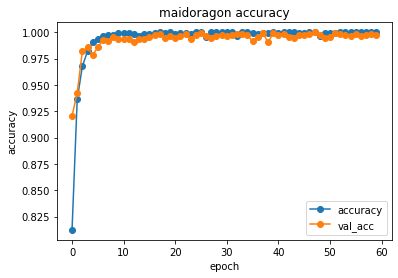

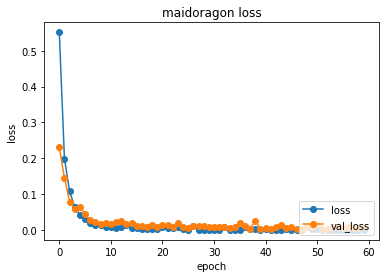

In [0]:
# 精度の履歴をプロット
plt.plot(history.history['acc'],"o-",label="accuracy")
plt.plot(history.history['val_acc'],"o-",label="val_acc")
plt.title('maidoragon accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc="lower right")
plt.show()

# 損失の履歴をプロット
plt.plot(history.history['loss'],"o-",label="loss",)
plt.plot(history.history['val_loss'],"o-",label="val_loss")
plt.title('maidoragon loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')
plt.show()

# キャラクターの画像分類をやってみよう
学習したニューラルネットを利用して、キャラクターの分類をやってみましょう。

In [0]:
model = keras.models.load_model(MODEL_PATH + MODEL_NAME)

結果：トール（確率：100.0パーセント）


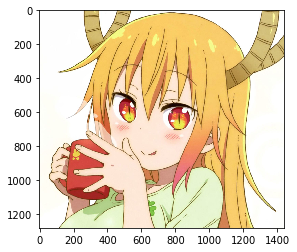

In [0]:
# 画像を読み込んで、ニューラルネットに入力できるよう、リサイズと正規化をしてから推測をさせます
IMG_PATH = 'drive/My Drive/kobayashi/toal.jpg' # 任意のパスに書き換えてください
im = Image.open(IMG_PATH)
plt.imshow(np.array(im))
im = im.resize((IMG_SIZE, IMG_SIZE))
im_data = np.array(im)

im_data = im_data.reshape(1, IMG_SIZE, IMG_SIZE, 3)
im_data.astype('float32')
im_data = im_data / 256

answer = model.predict(im_data)
names = ['小林', 'トール', 'カンナ', '滝谷']
print('結果：{}（確率：{}パーセント）'.format(names[np.argmax(answer)], (np.max(answer) * 100)))